<a href="https://colab.research.google.com/github/mikemoll84/Group-6-IOT-Final-Project/blob/main/Analysis_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import csv
from datetime import datetime
import warnings

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Filter out DeprecationWarnings
warnings.filterwarnings("ignore")

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
#from pmdarima.arima import auto_arima
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

##EDA/DATA CLEANING

In [8]:
# Load the compressed CSV data into a DataFrame
url = 'https://raw.githubusercontent.com/mikemoll84/Group-6-IOT-Final-Project/main/Metro_Interstate_Traffic_Volume.csv?token=GHSAT0AAAAAACM4T6OHLBOYOO2LKLEDDAKQZOT4J2Q'
df = pd.read_csv(url)
# Correcting the format for the 'date_time' column conversion
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
#Convert Kelvin to F
df['temp'] = (df['temp'] - 273.15) * 9/5 + 32
df['temp'] = df['temp'].round(0)

In [9]:
# Display the first few rows of the DataFrame
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,59.00000,0.00000,0.00000,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,61.00000,0.00000,0.00000,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,62.00000,0.00000,0.00000,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,63.00000,0.00000,0.00000,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,64.00000,0.00000,0.00000,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [10]:
# Display the DataFrame's basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              48204 non-null  object        
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.3+ MB


In [11]:
# Summary statistics for numerical columns
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.00000,48204.00000,48204.00000,48204.00000,48204.00000
mean,46.50033,0.33426,0.00022,49.36223,3259.81836
std,24.01466,44.78913,0.00817,39.01575,1986.86067
min,-460.00000,0.00000,0.00000,0.00000,0.00000
25%,30.00000,0.00000,0.00000,1.00000,1193.00000
50%,49.00000,0.00000,0.00000,64.00000,3380.00000
75%,66.00000,0.00000,0.00000,90.00000,4933.00000
max,98.00000,9831.30000,0.51000,100.00000,7280.00000


In [12]:
# Summary information for categorical columns
df.describe(include=['object', 'category'])

,holiday,weather_main,weather_description
count,48204,48204,48204
unique,12,11,38
top,None,Clouds,sky is clear
freq,48143,15164,11665


In [13]:
# Check for missing values
df.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

In [14]:
#Drop duplicate values
df.drop_duplicates(inplace=True)

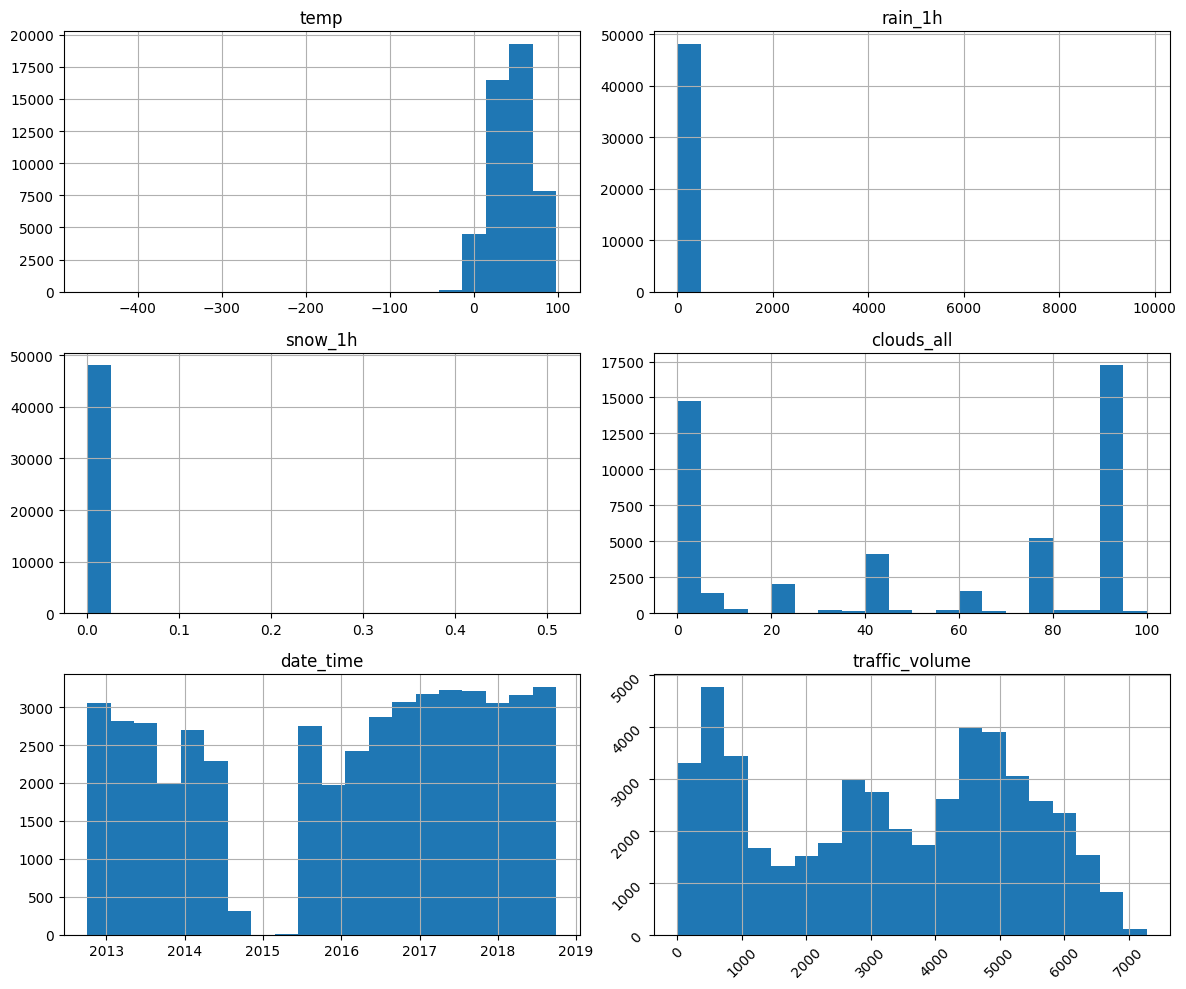

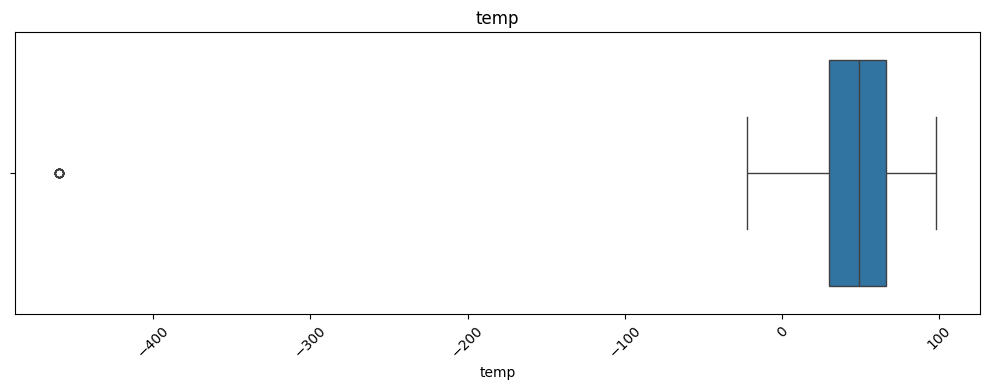

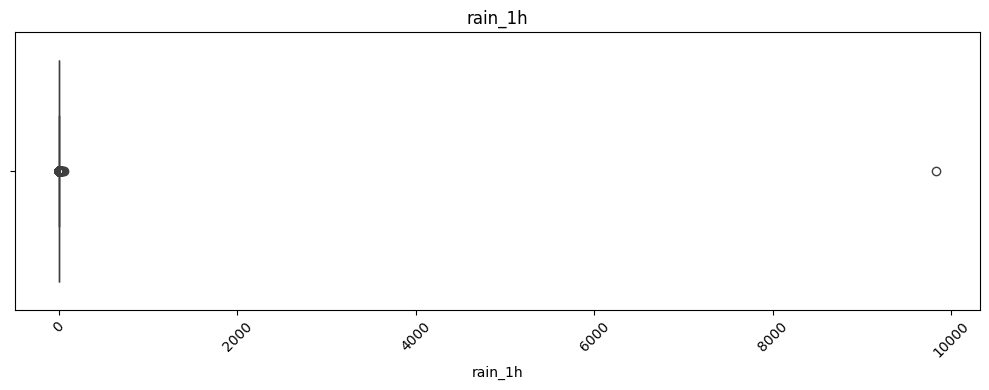

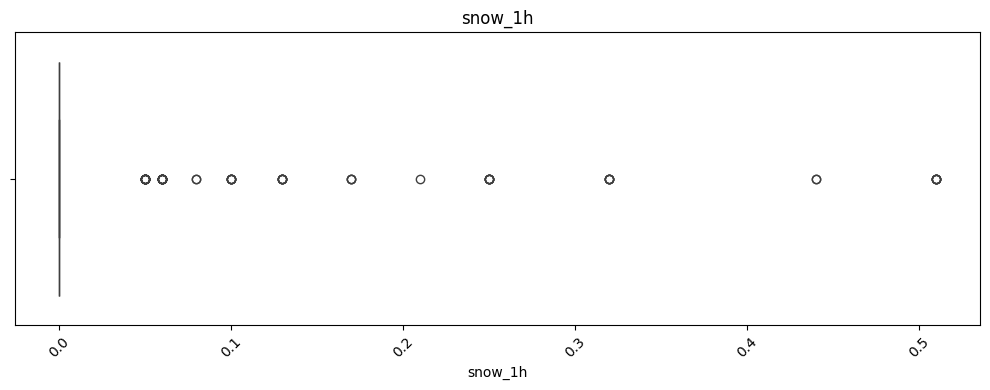

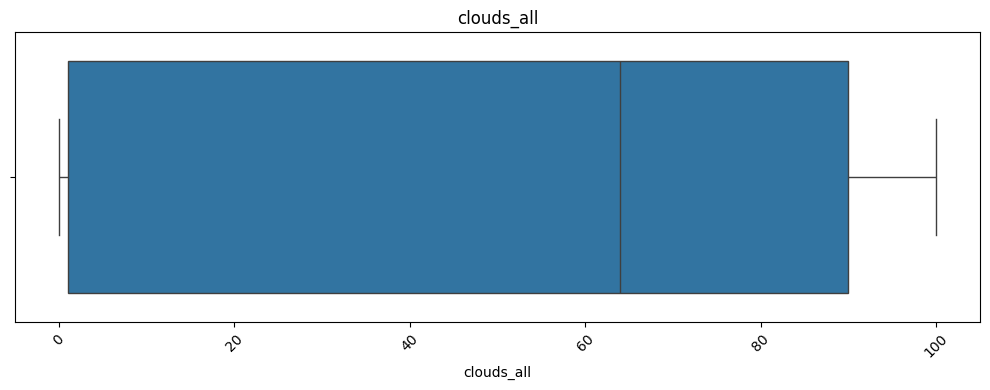

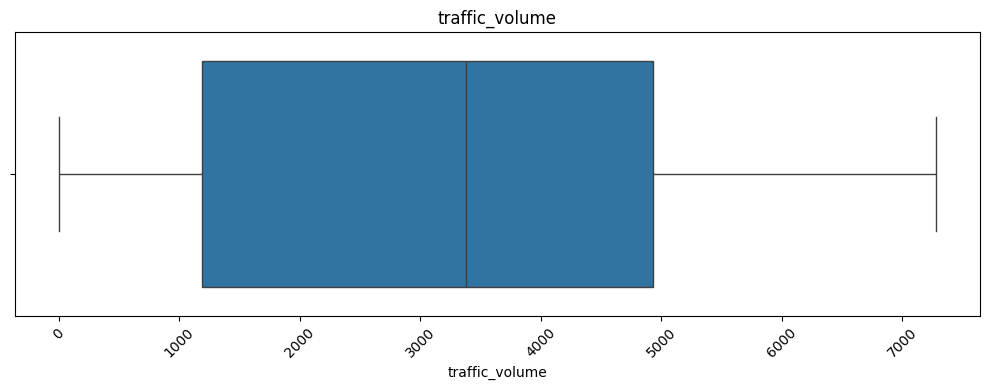

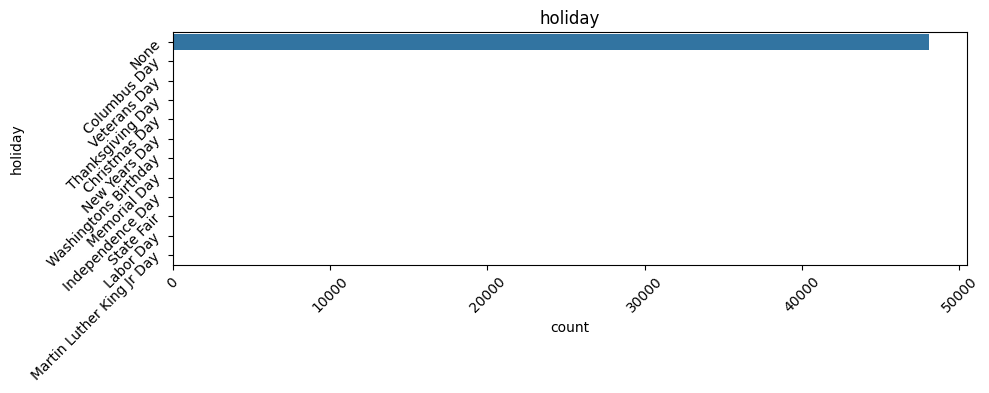

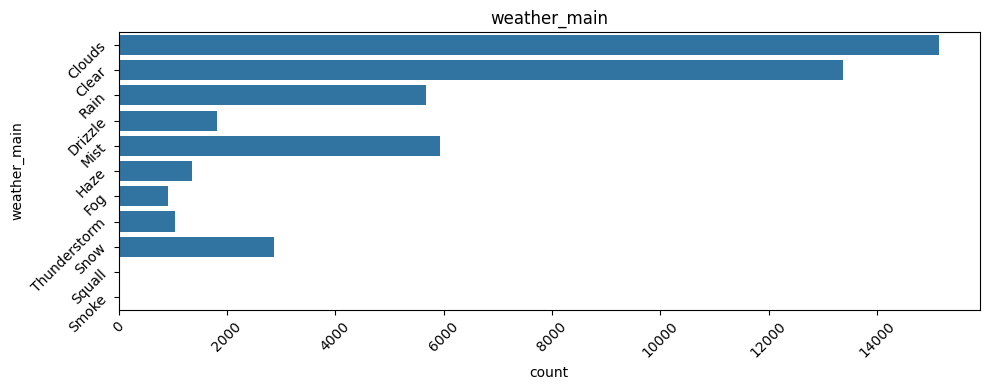

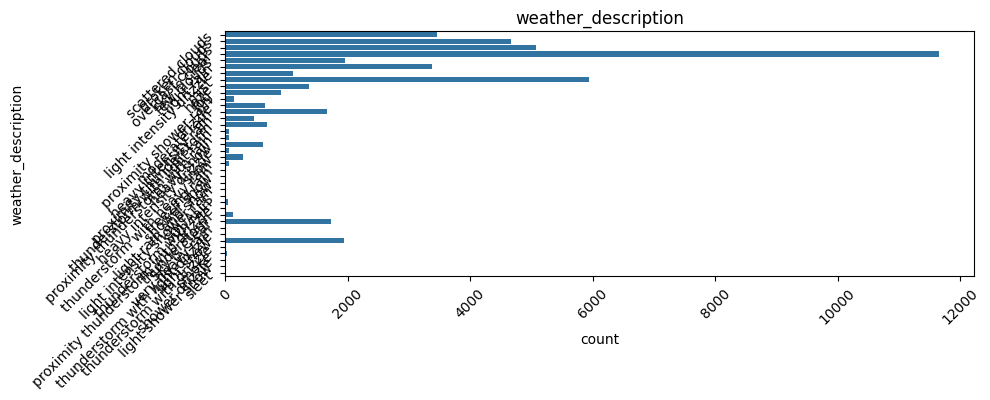

In [15]:
# Create histograms for numerical columns
df.hist(figsize=(12, 10), bins=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Box plots for numerical columns to check outliers
for column in df.select_dtypes(include=['float', 'int']).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[column])
    plt.title(column)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Bar charts for categorical columns
for column in df.select_dtypes(include=['object', 'category']).columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(y=df[column])
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title(column)
    plt.tight_layout()
    plt.show()


In [16]:
#Remove clear outlier in temperature
df = df[df['temp'] > -50]

In [17]:
#use datetime_is_numeric = True to get statistics on the datetime column
desc = df.describe(datetime_is_numeric = True)

#force the printout not to use scientific notation
desc[desc.columns[:-1]] = desc[desc.columns[:-1]].apply(lambda x: x.apply("{0:.4f}".format))
desc

,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume
count,48146.0000,48146.0000,48146.0000,48146.0000,48146.0000,48146.00000
mean,46.5976,0.3346,0.0002,49.3731,.4f,3259.48475
min,-22.0000,0.0000,0.0000,0.0000,.4f,0.00000
25%,30.0000,0.0000,0.0000,1.0000,.4f,1192.00000
50%,49.0000,0.0000,0.0000,64.0000,.4f,3378.00000
75%,66.0000,0.0000,0.0000,90.0000,.4f,4933.00000
max,98.0000,9831.3000,0.5100,100.0000,.4f,7280.00000
std,22.8784,44.8161,0.0082,39.0135,nan,1987.16643


In [18]:
#Creating moving average for data
moving_average_data = df.rolling(window=30).mean()
moving_average_data

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
48199,47.26667,0.00833,0.00000,86.00000,3073.06667
48200,47.33333,0.00833,0.00000,86.00000,3007.93333
48201,47.40000,0.00833,0.00000,86.00000,2917.30000
48202,47.46667,0.00833,0.00000,86.00000,2813.33333


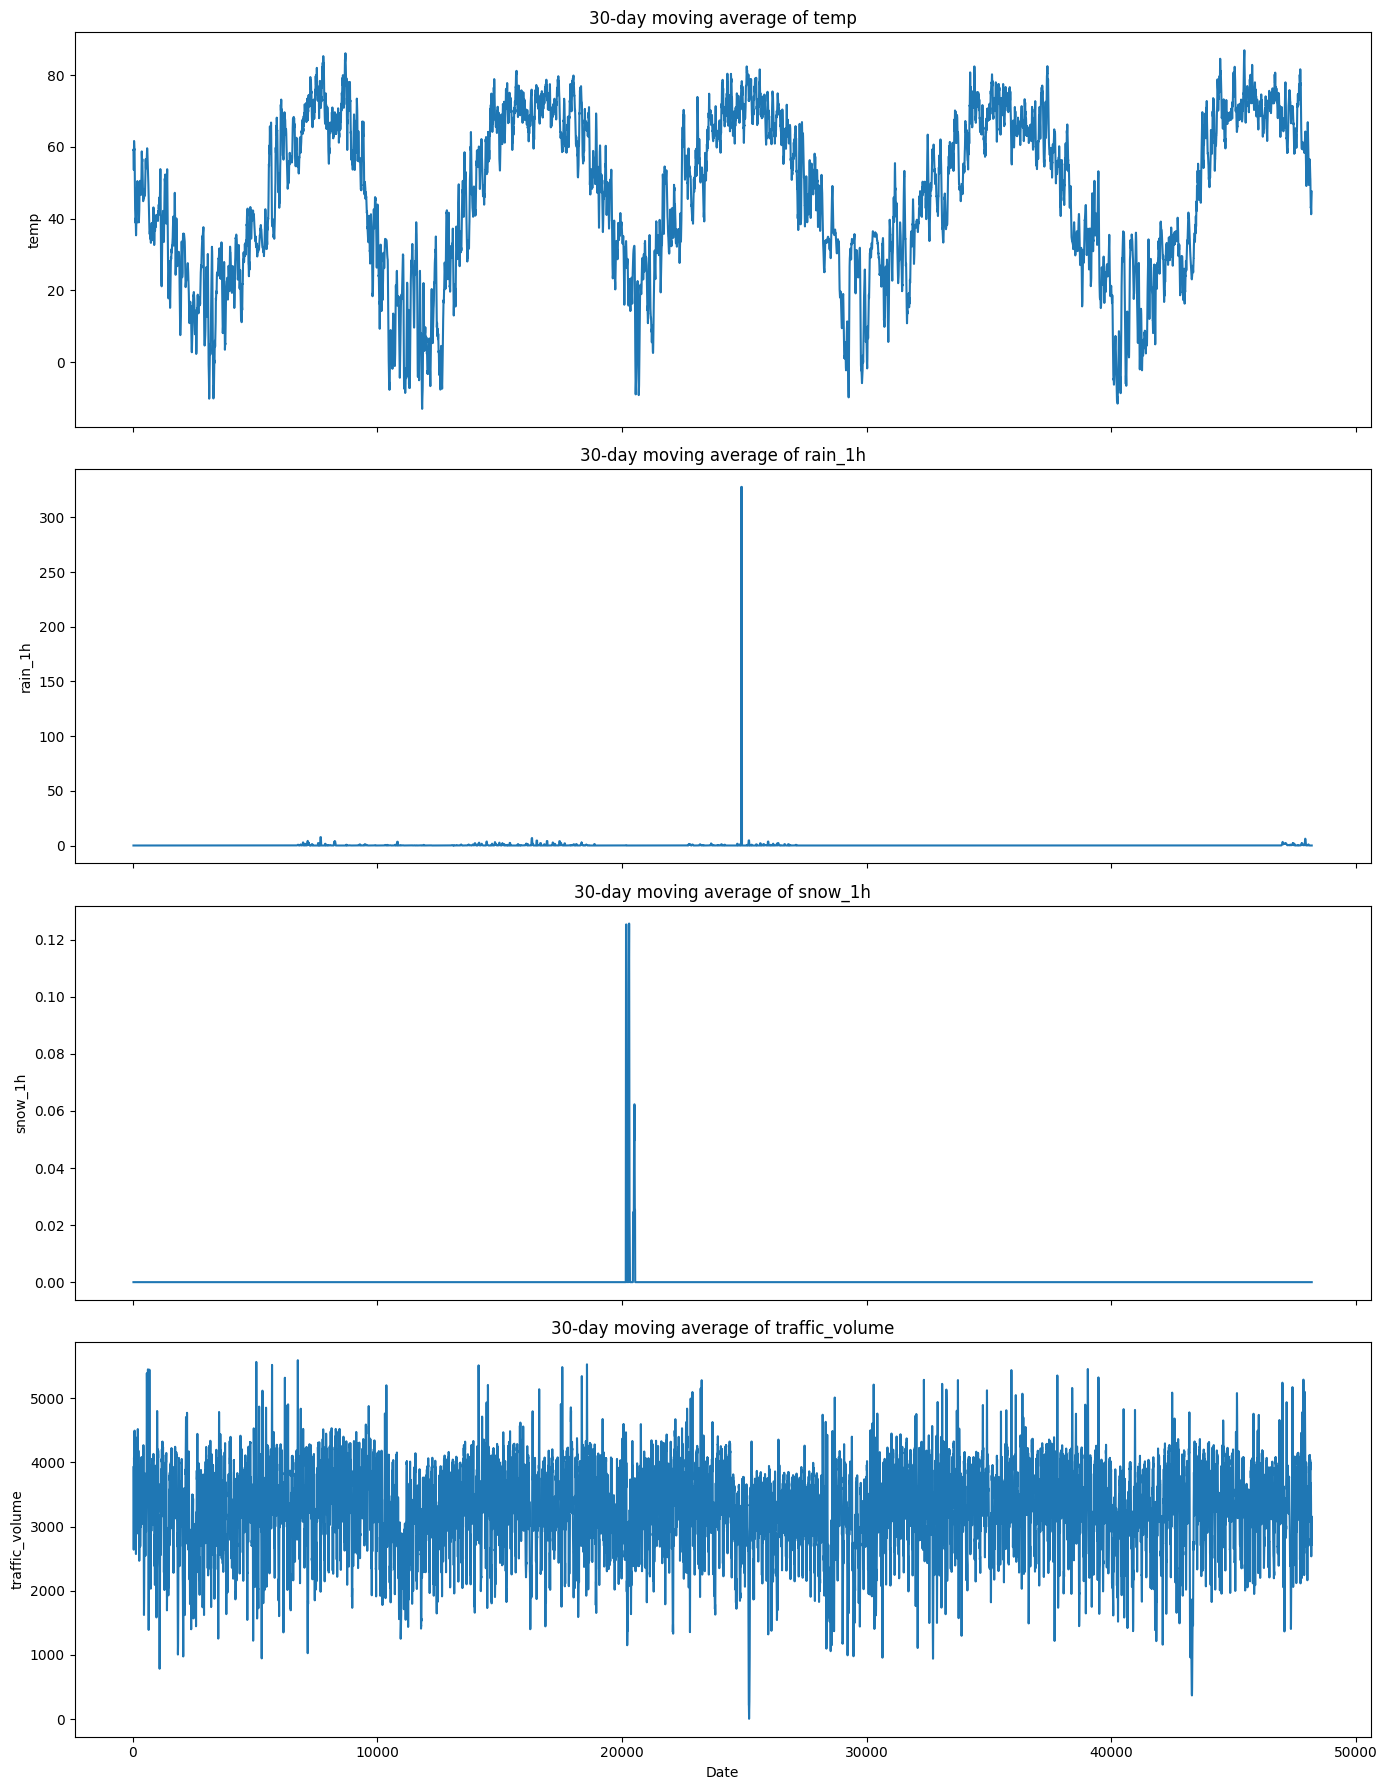

In [19]:
#build line chart on the moving average
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 18), sharex=True)

variables_to_plot = ['temp', 'rain_1h', 'snow_1h', 'traffic_volume']

for i, var in enumerate(variables_to_plot):
    moving_average_data[var].plot(ax=axes[i], title=f'30-day moving average of {var}')
    axes[i].set_ylabel(var)

# Set common X label
axes[-1].set_xlabel('Date')

plt.tight_layout()
plt.show()

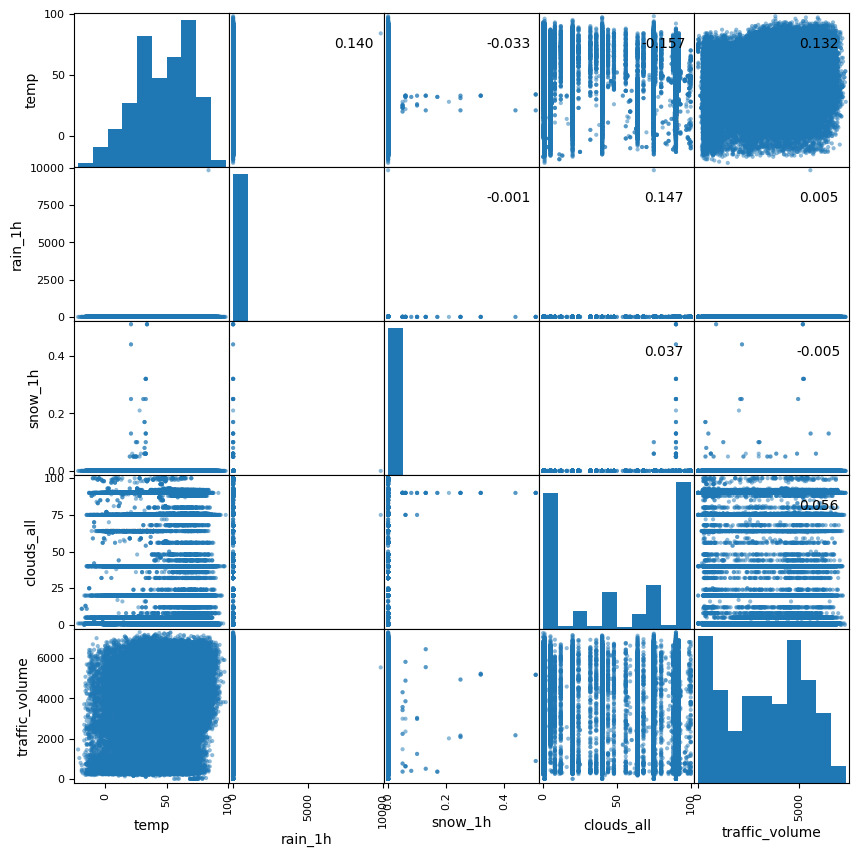

In [20]:
#Create correlation matrix
axes = pd.plotting.scatter_matrix(df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']], alpha=0.5,figsize = [10,10])
corr = df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']].corr(method = 'spearman').to_numpy() #nonlinear
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

## LINEAR REGRESSION MODEL

In [21]:
#Make copy of cleaned dataframe for deep learning model
data_clean = df.copy()
# Convert 'date_column' to datetime
df['datetime'] = pd.to_datetime(df['date_time'])
#convert datetime to epoch/unix time
df['unix'] = df['datetime'].apply(lambda x: int(x.timestamp()))
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,datetime,unix
0,None,59.00000,0.00000,0.00000,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2012-10-02 09:00:00,1349168400
1,None,61.00000,0.00000,0.00000,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,2012-10-02 10:00:00,1349172000
2,None,62.00000,0.00000,0.00000,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,2012-10-02 11:00:00,1349175600
3,None,63.00000,0.00000,0.00000,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2012-10-02 12:00:00,1349179200
4,None,64.00000,0.00000,0.00000,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2012-10-02 13:00:00,1349182800


In [22]:
def linreg (mu):
  ts = pd.DataFrame(df.unix)
  ys = pd.DataFrame(df.traffic_volume)

  # Using hourly data resolution
  data_res_min = 60  # 60 minutes
  ph_hours = 1  # 1 hour

  # Calculate pH and pH index
  ph = ph_hours * (60 / data_res_min)
  ph_index = int(60 / data_res_min)

  mu = mu #0.01 #0.05 #0.9

  # limit the number of samples in to 5000 for speed
  n_s = 5000

  # Arrays to hold predicted values
  tp_pred = np.zeros(n_s-1)
  yp_pred = np.zeros(n_s-1)

  # At every iteration of the for loop a new data sample is acquired
  for i in range(2, n_s+1):# start out with 2 leading datapoints
      #get x and y data "available" for our prediction
      ts_tmp = ts[0:i]
      ys_tmp = ys[0:i]
      ns = len(ys_tmp)


      weights = np.ones(ns)*mu
      for k in range(ns):
          #adjust weights to be downweighted according to their timestep away from our prediction
          weights[k] = weights[k]**k
      weights = np.flip(weights, 0)

      #perform linear regression on "available" data using the mu-adjusted weights
      lm_tmp = LinearRegression()
      model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

      #store model coefficients and intercepts to compute prediction
      m_tmp = model_tmp.coef_
      q_tmp = model_tmp.intercept_

      #use ph to make the model prediction according to the prediction time
      tp = ts.iloc[i-1,0] + ph
      yp = m_tmp*tp + q_tmp

      tp_pred[i-2] = tp
      yp_pred[i-2] = yp

  return tp_pred, yp_pred, ts, n_s, ys, mu, ph, ph_index

MSE is 0.053540685840509354


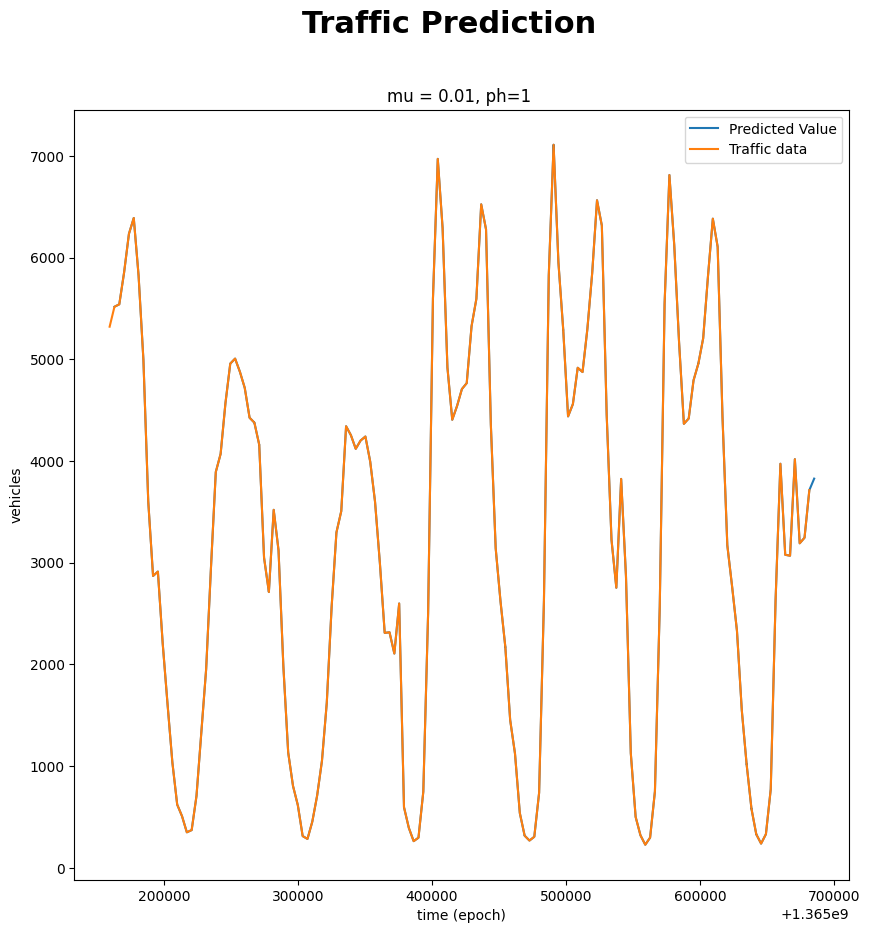

In [23]:
#call function on mu value of 0.01
tp_pred, yp_pred, ts, n_s, ys, mu, ph, ph_index = linreg(0.01)
#Plot last 200 data points/predictions
n_s = len(tp_pred)
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Traffic Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' % (mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='Traffic data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('vehicles')
ax.legend()
#Calculate MSE of the model
print("MSE is", mse(ys['traffic_volume'][ph_index:5000+ph_index-1],yp_pred))

MSE is 5.6606538214121045


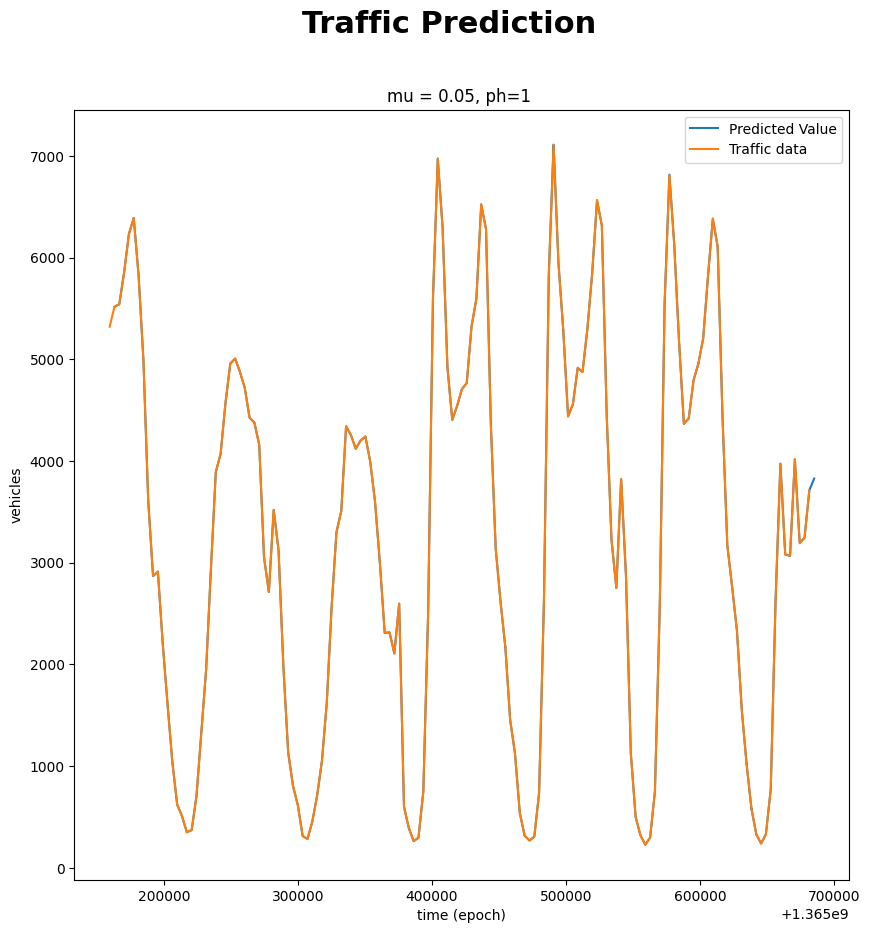

In [24]:
#call function on mu value of 0.05
tp_pred, yp_pred, ts, n_s, ys, mu, ph, ph_index = linreg(0.05)
#Plot last 200 data points/predictions
n_s = len(tp_pred)
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Traffic Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' % (mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='Traffic data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('vehicles')
ax.legend()
#Calculate MSE of the model
print("MSE is", mse(ys['traffic_volume'][ph_index:5000+ph_index-1],yp_pred))

MSE is 2099704.7118860562


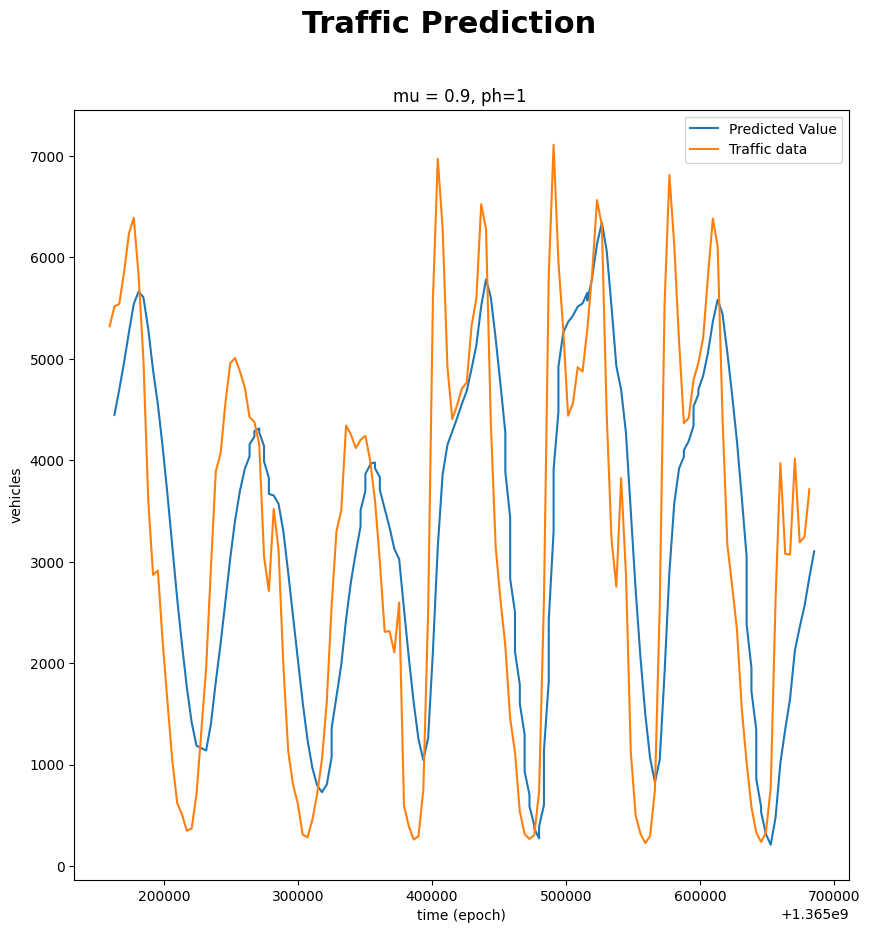

In [25]:
#call function on mu value of 0.9
tp_pred, yp_pred, ts, n_s, ys, mu, ph, ph_index = linreg(0.9)
#Plot last 200 data points/predictions
n_s = len(tp_pred)
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Traffic Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' % (mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='Traffic data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('vehicles')
ax.legend()
#Calculate MSE of the model
print("MSE is", mse(ys['traffic_volume'][ph_index:5000+ph_index-1],yp_pred))

## ARIMA MODEL

In [26]:
#Copy cleaned dataset
df = data_clean.copy()
df['datetime'] = pd.to_datetime(df['date_time'])
df['unix'] = df['datetime'].astype(int) // 10**9
df_copy = df.filter(['unix','traffic_volume'], axis=1)
df_copy.head()

,unix,traffic_volume
0,1349168400,5545
1,1349172000,4516
2,1349175600,4767
3,1349179200,5026
4,1349182800,4918


In [27]:
# Data is split into train and test set and boolean mask created where training
# set contains all rows for df except the last 30 that belong to the testing set
df_traffic = df.filter(['traffic_volume'], axis=1)
msk = (df_traffic.index < len(df_copy)-30)
train = df_traffic[msk].copy()
test = df_traffic[~msk].copy()

p-value: 0.0


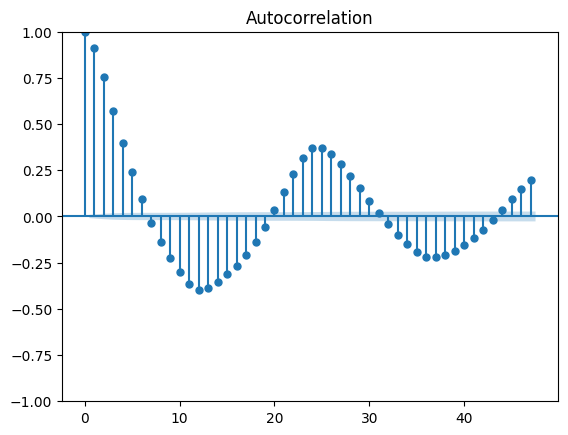

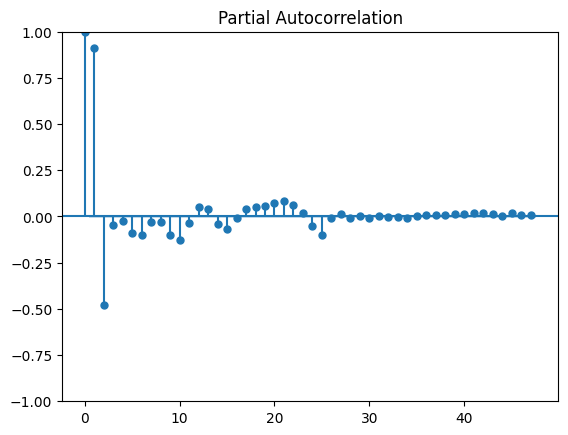

In [28]:
#Plot correlation plots and print p-value
acf_original = plot_acf(train)
pacf_original = plot_pacf(train)

adf_test = adfuller(train)
print(f'p-value: {adf_test[1]}')

In [29]:
#Print model summary
#Based on Dickey-Fuller test data is stationary and d=1
#Based on the correlation plot the order is(p,d,0)
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         traffic_volume   No. Observations:                48059
Model:                 ARIMA(2, 1, 0)   Log Likelihood             -386602.448
Date:                Mon, 19 Feb 2024   AIC                         773210.897
Time:                        23:23:06   BIC                         773237.237
Sample:                             0   HQIC                        773219.163
                              - 48059                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4443      0.003    177.264      0.000       0.439       0.449
ar.L2         -0.0687      0.004    -19.341      0.000      -0.076      -0.062
sigma2      5.686e+05   1678.491    338.781      0.0

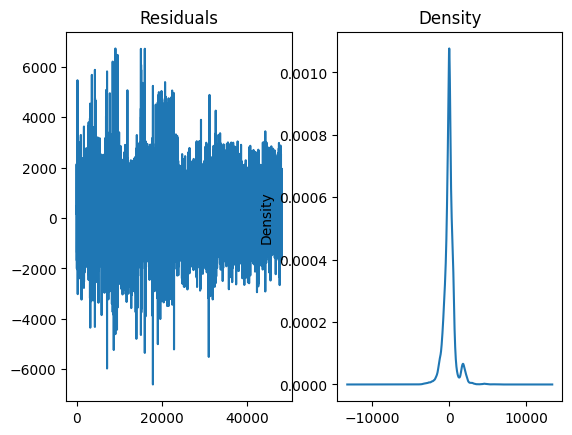

In [30]:
#Plot residuals and density
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

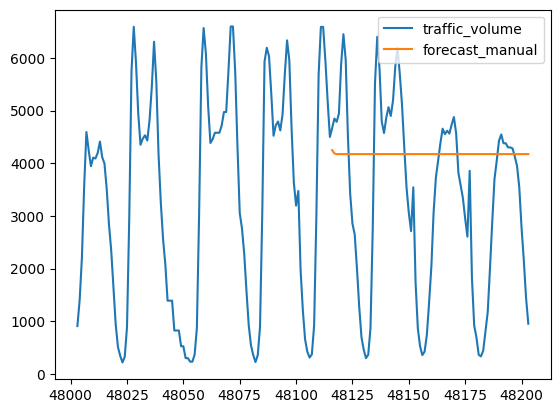

In [31]:
#Plot the model predictions using Manual ARIMA model
forecast_test = model_fit.forecast(steps=len(test))
df_traffic['forecast_manual'] = [None]*len(train) + list(forecast_test)

last_200_points = df_traffic.iloc[-200:]
# Plot the last 200 data points
last_200_points.plot()
# Show the plot
plt.show()

In [32]:
#Creat auto ARIMA model
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
print(auto_arima)
auto_arima.summary()

 ARIMA(1,0,4)(0,0,0)[0]          


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                48059
Model:               SARIMAX(1, 0, 4)   Log Likelihood             -385853.984
Date:                Mon, 19 Feb 2024   AIC                         771719.968
Time:                        23:29:13   BIC                         771772.649
Sample:                             0   HQIC                        771736.500
                              - 48059                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9496      0.002    452.408      0.000       0.945       0.954
ma.L1          0.4656      0.003    137.031      0.000       0.459       0.472
ma.L2          0.1998      0.005     37.740      0.000       0.189       0.210
ma.L3          0.0132      0.006      2.323      0.020       0.002       0.024
ma.L4         -0.0418      0.005     -9.006      0.000      -0.051      -0.033
sigma2      5.553e+05   1619.577    342.879      0.000    5.52e+05    5.58e+05
===================================================================================
Ljung-Box (L1) (Q):                  17.14   Jarque-Bera (JB):            129832.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
#Find necessary order of differences
ndiffs(df_traffic.traffic_volume, test='adf')

0

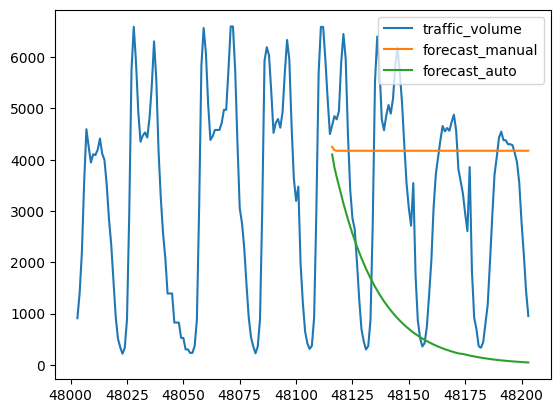

In [34]:
#Plot model predictions using the auto and manual ARIMA models
forecast_test_auto = auto_arima.predict(n_periods=len(test))
df_traffic['forecast_auto'] = [None]*len(train) + list(forecast_test_auto)

last_200_points = df_traffic.iloc[-200:]
# Plot the last 200 data points
last_200_points.plot()
# Show the plot
plt.show()

In [35]:
#Calculate model performance
mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test)
rmse = np.sqrt(mse(test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae = mean_absolute_error(test, forecast_test_auto)
mape = mean_absolute_percentage_error(test, forecast_test_auto)
rmse = np.sqrt(mse(test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - manual: 1538.9872303366426
mape - manual: 1.710031804638932
rmse - manual: 1977.4739696356178
mae - auto: 2579.0007104884426
mape - auto: 0.8713641921677222
rmse - auto: 3017.6611687016757


##DEEP LEARNING MODEL

In [36]:
#Make copy of cleaned dataframe for deep learning model
data = data_clean.copy()
data = data['temp'].values.astype('float32')

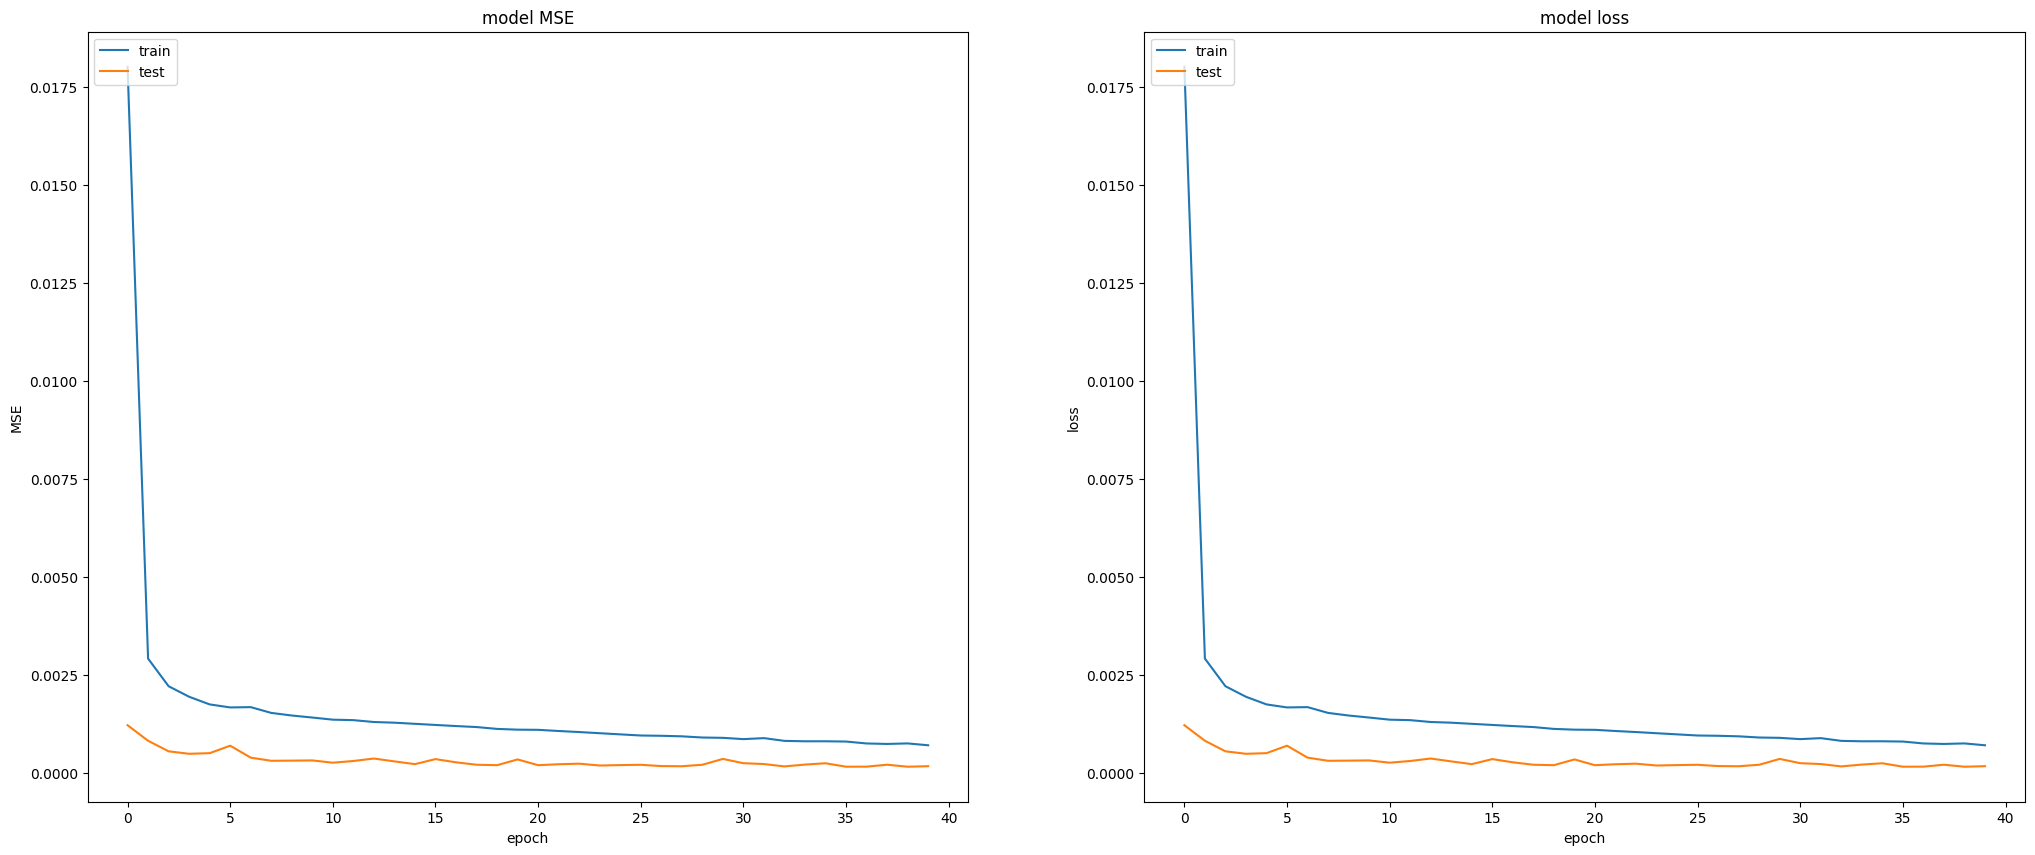

In [37]:
#Convert to numpy array and split into training and testing sets
data = np.reshape(data, (len(data),1))
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size,:], data[train_size:len(data),:]

#Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

#Create training and testing data and reshape for LSTM
x_train,y_train = [],[]
x_test, y_test = [], []

window_size = 12
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#Build the RNN and LSTM models, compile, and train
model = tf.keras.models.Sequential([
    # tf.keras.layers.LSTM(100, input_shape=(window_size, 1)),
    tf.keras.layers.SimpleRNN(100, input_shape=(window_size, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('relu')
])

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
model_path = 'LSTM_model3.h5'
history = model.fit(x_train, y_train, epochs=40, batch_size=500, validation_split=0.05, verbose=0,
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

# summarize history for MSE
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
ax1.plot(history.history['mse'])
ax1.plot(history.history['val_mse'])
ax1.set_title('model MSE')
ax1.set_ylabel('MSE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for Loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

301/301 [==============================] - 1s 3ms/step
Root Mean Squared Error: 0.3
1/1 [==============================] - 0s 175ms/step


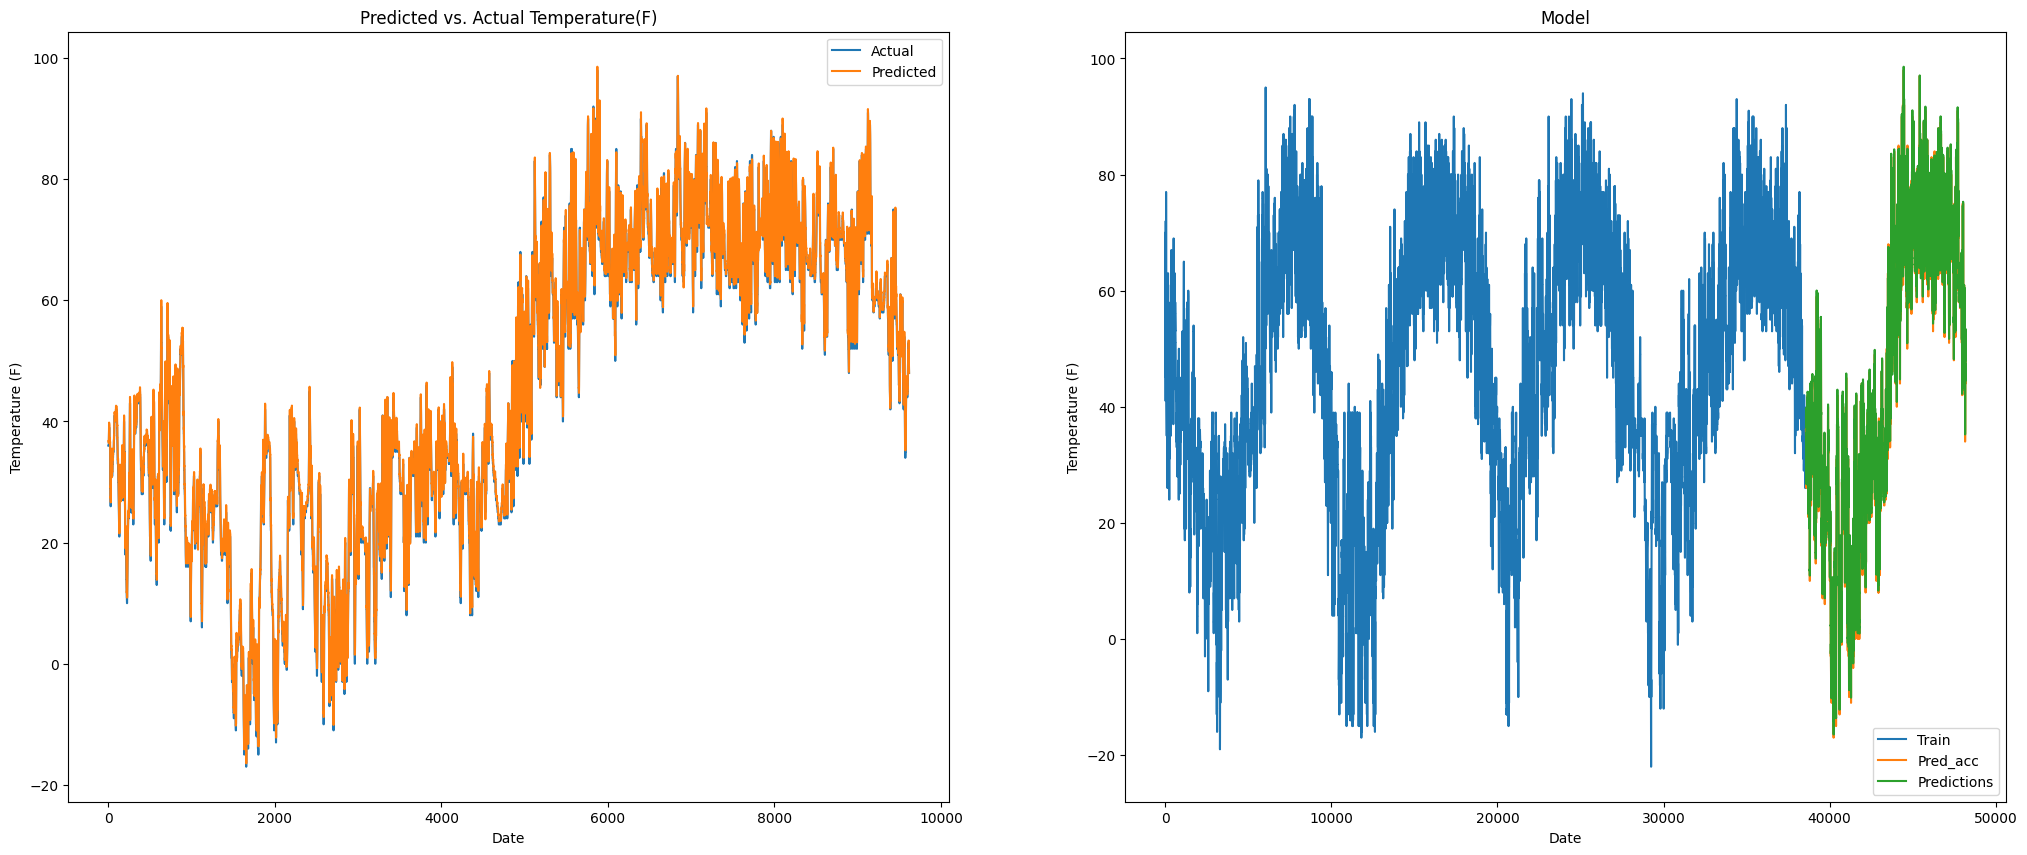

In [38]:
#Evaluate and make predications on the test data
mse = model.evaluate(x_test, y_test)
predictions = model.predict(x_test)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('Root Mean Squared Error:', round(rmse,3))

#Denormalize the values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

#Create a single prediction given the history of the temperatures
single = [test_data[len(test_data) + 1 - window_size:len(test_data + 1), 0]]
single = np.array(single)
single = np.reshape(single, (single.shape[0], single.shape[1], 1))
single_pred = model.predict(single)
single_pred = scaler.inverse_transform(single_pred)

#Graph a comparison between the actual values and the predicted values
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
ax1.plot(y_test, label='Actual')
ax1.plot(predictions, label='Predicted')
ax1.set_title('Predicted vs. Actual Temperature(F)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (F)')
ax1.legend()

#Plot the predictions with the historical temperatures
train = df[:train_size]
valid = df[train_size:]
pred = df[train_size+window_size:]
pred['Predictions'] = predictions
ax2.set_title('Model')
ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature (F)')
ax2.plot(train['temp'])
ax2.plot(valid['temp'])
ax2.plot(pred['Predictions'])
ax2.legend(['Train','Pred_acc','Predictions'], loc='lower right')
plt.show()